In [1]:
from pysimplesoap.client import SoapClient
from suds.client import Client
from datetime import datetime
import pytz
import untangle
import pandas as pd
import numpy as np
import itertools
%matplotlib inline

In [2]:
def event_client_datetime(event, tz_server, tz_client='Europe/Amsterdam'):
    """
    Get datetime object in client time of an XML Element named event with attributes date and time
    input:
    event     : XML Element named event [eg: obj.TimeSeries.series.event[0]]
    tz_server : datetime abbreviation of the server timezone [eg: 'Etc/GMT']
    tz_client : datetime abbreviation of the client timezone [eg: 'Europe/Amsterdam']

    return
    event_client_time : an datetime object of the event in client timezome

    """    
    # convert XML element date string to integer list
    event_server_date = list(map(int, event['date'].split('-'))) # -> [yyyy, MM, dd]
    event_server_time = list(map(int, event['time'].split(':'))) # -> [HH, mm, ss]
    
    # define server time
    server_time = datetime(event_server_date[0], event_server_date[1], event_server_date[2], 
                           event_server_time[0], event_server_time[1], event_server_time[2], 
                           tzinfo=pytz.timezone(tz_server))    
    client_timezone = pytz.timezone(tz_client)

    # returns datetime in the new timezone
    event_client_time = server_time.astimezone(client_timezone)     
    
    return event_client_time

In [3]:
url = 'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl'
client = Client(url)
#print( SoapClient(wsdl=url,trace=False) )

In [4]:
# get TimeZone identifier from the FEWS PI Service
timeZoneID = client.service.getTimeZoneId()
print (timeZoneID)

GMT


In [5]:
# create the service input xml
getTimeSeries = client.factory.create('getTimeSeries')

# fill in the query parameters
getTimeSeries.queryParams.convertDatum = 'false'
getTimeSeries.queryParams.omitMissing = 'false'
getTimeSeries.queryParams.onlyHeaders = 'false'
getTimeSeries.queryParams.moduleInstanceIds = 'pr.Reizen.vdLee.baggeracties'
getTimeSeries.queryParams.locationIds = ['bv.1.7.2.1.1','bv.1.7.2.3.2']
getTimeSeries.queryParams.parameterIds = 'k.m3.zandwinning.vdlee'
getTimeSeries.queryParams.startTime = '2016-08-01T02:00:00.0+02:00'#'2016-08-01 02:00'
getTimeSeries.queryParams.endTime = '2017-02-01T01:00:00.0+01:00'#'2017-04-01 02:00'
getTimeSeries.queryParams.version = '1.22'

# print the query
#print (getTimeSeries.queryParams)

# execute the query
getTimeSeries_response = client.service.getTimeSeries(getTimeSeries.queryParams)

In [6]:
print (getTimeSeries_response)

<?xml version="1.0" encoding="UTF-8"?>
<TimeSeries xmlns="http://www.wldelft.nl/fews/PI" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.wldelft.nl/fews/PI http://fews.wldelft.nl/schemas/version1.0/pi-schemas/pi_timeseries.xsd" version="1.22" xmlns:fs="http://www.wldelft.nl/fews/fs">
    <timeZone>0.0</timeZone>
    <series>
        <header>
            <type>instantaneous</type>
            <moduleInstanceId>pr.Reizen.vdLee.baggeracties</moduleInstanceId>
            <locationId>bv.1.7.2.3.2</locationId>
            <parameterId>k.m3.zandwinning.vdlee</parameterId>
            <timeStep unit="second" multiplier="86400"/>
            <startDate date="2016-07-31" time="23:00:00"/>
            <endDate date="2017-02-01" time="23:00:00"/>
            <missVal>-999.0</missVal>
            <stationName>Blauwe Slenk</stationName>
            <lat>53.198056100473764</lat>
            <lon>5.306253896524052</lon>
            <x>149590.0</x>
            <y>5

In [12]:
obj = untangle.parse(getTimeSeries_response)

In [13]:
# fill list with stationNames
series_stationNames = []
event_datetimes = []
event_values = []
event_flags = []
event_attributes = ['value','flag']

events_values = []
events_flags = []

for series in obj.TimeSeries.series:
    series_stationNames.append(series.header.stationName.cdata)
    for event in series.event:     
        event_values.append( float(event['value']))
        event_flags.append( int(event['flag']))

    events_values.append(event_values)
    events_flags.append(event_flags)
        
    #event_datetimes = []
    event_values = []
    event_flags = []

# only once select the datetimes    
for event in series.event:     
    event_datetimes.append( event_client_datetime(event, tz_server='Etc/'+timeZoneID, tz_client='Europe/Amsterdam'))
    

#listcombine_T = list(map(list, zip(*[events_values,events_flags])))
listcombine = [events_values,events_flags]
multiColumns = (list(itertools.product(series_stationNames, event_attributes)))
#df = pd.DataFrame(listcombine,columns=multiColumns)
#df.columns = pd.MultiIndex.from_tuples(df.columns, names=['locationId','attributes'])

In [14]:
series_stationNames

['Blauwe Slenk', 'Slenk']

In [15]:
df_ = pd.DataFrame(index=event_datetimes, columns=series_stationNames)
df_ = df_.fillna(0) # with 0s rather than NaNs
df_.head()

,Blauwe Slenk,Slenk
2016-08-01 01:00:00+02:00,0,0
2016-08-02 01:00:00+02:00,0,0
2016-08-03 01:00:00+02:00,0,0
2016-08-04 01:00:00+02:00,0,0
2016-08-05 01:00:00+02:00,0,0


In [16]:
# fill the lists of dateTimes, values and flags
event_datetimes = []
event_values = []
event_flags = []
for event in obj.TimeSeries.series.event:     
    event_datetimes.append( event_client_datetime(event, tz_server='Etc/'+timeZoneID, tz_client='Europe/Amsterdam'))
    event_values.append( float(event['value']))
    event_flags.append( int(event['flag']))

AttributeError: 'list' object has no attribute 'event'

In [53]:
moduleInstanceIds = []
locationIds = []
parameterIds = []

event_datetimes = []
event_values = []
event_flags = []

for series in obj.TimeSeries.series:
    # collect metadata    
    # moduleInstanceId, locationId and parameterId
    moduleInstanceIds.append(series.header.moduleInstanceId.cdata)
    locationIds.append(series.header.locationId.cdata)
    parameterIds.append(series.header.parameterId.cdata)
    
    for event in series.event:
        event_datetimes.append( event_client_datetime(event, tz_server='Etc/'+timeZoneID, tz_client='Europe/Amsterdam'))
        event_values.append( float(event['value']))
        event_flags.append( int(event['flag']))

[2016, 7, 31]
[2016, 8, 1]
[2016, 8, 2]
[2016, 8, 3]
[2016, 8, 4]
[2016, 8, 5]
[2016, 8, 6]
[2016, 8, 7]
[2016, 8, 8]
[2016, 8, 9]
[2016, 8, 10]
[2016, 8, 11]
[2016, 8, 12]
[2016, 8, 13]
[2016, 8, 14]
[2016, 8, 15]
[2016, 8, 16]
[2016, 8, 17]
[2016, 8, 18]
[2016, 8, 19]
[2016, 8, 20]
[2016, 8, 21]
[2016, 8, 22]
[2016, 8, 23]
[2016, 8, 24]
[2016, 8, 25]
[2016, 8, 26]
[2016, 8, 27]
[2016, 8, 28]
[2016, 8, 29]
[2016, 8, 30]
[2016, 8, 31]
[2016, 9, 1]
[2016, 9, 2]
[2016, 9, 3]
[2016, 9, 4]
[2016, 9, 5]
[2016, 9, 6]
[2016, 9, 7]
[2016, 9, 8]
[2016, 9, 9]
[2016, 9, 10]
[2016, 9, 11]
[2016, 9, 12]
[2016, 9, 13]
[2016, 9, 14]
[2016, 9, 15]
[2016, 9, 16]
[2016, 9, 17]
[2016, 9, 18]
[2016, 9, 19]
[2016, 9, 20]
[2016, 9, 21]
[2016, 9, 22]
[2016, 9, 23]
[2016, 9, 24]
[2016, 9, 25]
[2016, 9, 26]
[2016, 9, 27]
[2016, 9, 28]
[2016, 9, 29]
[2016, 9, 30]
[2016, 10, 1]
[2016, 10, 2]
[2016, 10, 3]
[2016, 10, 4]
[2016, 10, 5]
[2016, 10, 6]
[2016, 10, 7]
[2016, 10, 8]
[2016, 10, 9]
[2016, 10, 10]
[2016, 10

In [52]:
# print datetime of last event
test_event_time = event_client_datetime(event, tz_server='Etc/'+timeZoneID, tz_client='Europe/Amsterdam')
print (test_event_time.isoformat())

2017-02-02T00:00:00+01:00


In [70]:
listcombine_T = list(map(list, zip(*[event_values,event_flags])))
multiColumns=[('bv.1.7.2.1.1', 'value'), ('bv.1.7.2.1.1','flag')]
df = pd.DataFrame(listcombine_T,columns=multiColumns)
df.columns = pd.MultiIndex.from_tuples(df.columns, names=['locationId','attributes'])
#df.set_index(['datetime'], inplace=True)
#df['value'].replace(-999.,np.NaN,inplace=True)

In [71]:
df.head()

locationId              bv.1.7.2.1.1            
attributes                  datetime  value flag
0          2016-08-01 01:00:00+02:00 -999.0    8
1          2016-08-02 01:00:00+02:00 -999.0    8
2          2016-08-03 01:00:00+02:00 -999.0    8
3          2016-08-04 01:00:00+02:00 -999.0    8
4          2016-08-05 01:00:00+02:00 -999.0    8

In [76]:
#df.set_index('bv.1.7.2.1.1','datetime')
# set datetime as index from multiColumn, and remove the same column from the multiColumn
df.set_index([('bv.1.7.2.1.1', 'datetime')]).rename(
    columns=df.columns.to_series().to_dict())#.columns
df.replace(-999.,np.NaN,inplace=True)

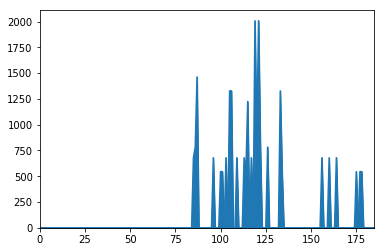

In [78]:
df['bv.1.7.2.1.1']['value'].plot(kind='area')